In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=a1a61dec47a8697dd0bc1436e9e617da3c73ef7f112be69ca0b33825183381f3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import time
import tqdm
import os

from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
from efficientnet_pytorch import EfficientNet

In [3]:
# kaggle.json파일 다운로드
# kaggle 사이트의 토큰을 가져오면 됨

In [4]:
# /content/ 폴더에 kaggle.json을 업로드 (매번 colab노트북 생성시 반복)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"youkyunghong","key":"2eff6a519f73e882d54ec2d0fded324d"}'}

In [5]:
# 파이썬 코드로 root디렉토리아래에 캐글폴더 만들고
# json파일 복사하기

import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
path = os.getcwd()

# 파일을 복사하는데, 이미 복사된 경우 복사하지 않는다.
if not os.path.exists(os.path.join('/root/.kaggle','kaggle.json')):
    src = os.path.join(path,'kaggle.json')
    dst = os.path.join('/root/.kaggle', 'kaggle.json')
    shutil.copy(src,dst)
    print('파일 복사 완료')

파일 복사 완료


In [6]:
# kaggle의 kaggle.json 파일을 /root/.kaggle/kaggle.json
# /content/ 폴더에 kaggle.json 업로드

!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json

In [7]:
!ls -al /root/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Sep 29 02:14 .
drwx------ 1 root root 4096 Sep 29 02:14 ..
-rw-r--r-- 1 root root   68 Sep 29 02:14 kaggle.json


In [8]:
# # 1. 압축 파일 풀기(로컬용)
# def extract_zip(zip_path, extract_to):
#     """
#     압축 파일을 풀어서 지정된 경로에 저장하는 함수
#     """
#     if os.path.exists(zip_path):
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_to)
#         print(f"압축이 풀렸습니다: {zip_path}")
#     else:
#         print(f"파일이 존재하지 않습니다: {zip_path}")

In [9]:
# 데이터 집파일 다운로드
!chmod 700 /root/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:44<00:00, 19.1MB/s]
100% 812M/812M [00:44<00:00, 19.0MB/s]


### 로컬환경에서 이미지 압축파일을 업로드 하기위한 코드

In [ ]:
from IPython.display import display
from ipywidgets import FileUpload

upload_widget = FileUpload()
display(upload_widget)

# 선택한 파일을 확인하려면 아래 코드를 실행하세요.
# upload_widget.value는 딕셔너리 형태로 업로드된 파일을 반환합니다.
for filename in upload_widget.value:
    print(f"Uploaded file: {filename}")

# zip 파일도 여기서 업로드할 수 있는지 확인하자

In [10]:
# 구글 드라이브 마운트 하지 않고, 구글 드라이브 파일 다운로드 받기
import gdown
gdown.download(id='1TAXL6bbZf-ro36hlu4KnKmwxUR4DrBno', output='requirements.txt')

Downloading...
From: https://drive.google.com/uc?id=1TAXL6bbZf-ro36hlu4KnKmwxUR4DrBno
To: /content/requirements.txt
100%|██████████| 965/965 [00:00<00:00, 3.34MB/s]


'requirements.txt'

In [11]:
path = os.getcwd()
# data = os.path.join(path, 'data')
print(path)

/content


In [12]:
# 압축파일 풀기 :하위 폴더 data에 풀기
!unzip -qq dogs-vs-cats.zip -d data

In [13]:
# 2. 경로 설정 및 압축파일 풀기
import zipfile

data = os.path.join(path,'data')
train_data = os.path.join(data,'train')
test_data = os.path.join(data,'test1')

zip_file = zipfile.ZipFile(os.path.join(data,'train.zip'))
zip_file.extractall(path=data)
zip_file.close()

zip_file = zipfile.ZipFile(os.path.join(data,'test1.zip'))
zip_file.extractall(path=data)
zip_file.close()

In [14]:
# # 2. 경로 설정 및 압축 풀기
# train_zip = os.path.abspath('train.zip')
# test_zip = os.path.abspath('test1.zip')
# extract_to = path  # 데이터를 풀 폴더 경로

In [15]:
# # 데이터를 풀 폴더가 존재하지 않으면 생성
# os.makedirs(extract_to, exist_ok=True)

# # 압축 풀기 실행
# extract_zip(train_zip, extract_to)
# extract_zip(test_zip, extract_to)

In [16]:
import os

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: /content


In [17]:
# # 3. Train/Validation 데이터 분리 (파일 목록을 트레인과 밸리드로 나누기)
# train_data_dir = os.path.join(extract_to, 'train')
# test_data_dir = os.path.join(extract_to, 'test1')

# train_files = os.listdir(train_data_dir)
# train_dog_files = [f for f in train_files if 'dog' in f]
# train_cat_files = [f for f in train_files if 'cat' in f]

# # Train 데이터에서 80%는 Train, 20%는 Validation으로 나누기
# dog_train_files, dog_valid_files = train_test_split(train_dog_files, test_size=0.2, random_state=42)
# cat_train_files, cat_valid_files = train_test_split(train_cat_files, test_size=0.2, random_state=42)

# print(f"Train set: {len(dog_train_files)} dogs, {len(cat_train_files)} cats")
# print(f"Validation set: {len(dog_valid_files)} dogs, {len(cat_valid_files)} cats")

In [18]:
# small dataset 4000장을 위한 폴더를 지정하고 거기에 4000장을 나눠서 보관하기

# 폴더명(경로)
sdata = 'sdata'
train_sdata = os.path.join(sdata, 'train')
valid_sdata = os.path.join(sdata, 'valid')
test_sdata = os.path.join(sdata, 'test')

# 폴더만들기
os.makedirs(train_sdata, exist_ok=True)
os.makedirs(valid_sdata, exist_ok=True)
os.makedirs(test_sdata, exist_ok=True)

# 하위 폴더 만들기(train)
train_sdata_dog = os.path.join(train_sdata, 'dog')
train_sdata_cat = os.path.join(train_sdata, 'cat')
os.makedirs(train_sdata_dog, exist_ok=True)
os.makedirs(train_sdata_cat, exist_ok=True)


# 하위 폴더 만들기(valid)
valid_sdata_dog = os.path.join(valid_sdata, 'dog')
valid_sdata_cat = os.path.join(valid_sdata, 'cat')
os.makedirs(valid_sdata_dog, exist_ok=True)
os.makedirs(valid_sdata_cat, exist_ok=True)


# # 하위 폴더 만들기(test)
# test_sdata_dog = os.path.join(test_sdata, 'dog')
# test_sdata_cat = os.path.join(test_sdata, 'cat')
# os.makedirs(test_sdata_dog, exist_ok=True)
# os.makedirs(test_sdata_cat, exist_ok=True)

In [19]:
# 존재한다면 리스트로 만들어주기

dogList = []
catList = []

for i in range(2000):
    dogList.append('dog.'+str(i)+'.jpg')
    catList.append('cat.'+str(i)+'.jpg')

In [20]:
print(dogList)
print(catList)

['dog.0.jpg', 'dog.1.jpg', 'dog.2.jpg', 'dog.3.jpg', 'dog.4.jpg', 'dog.5.jpg', 'dog.6.jpg', 'dog.7.jpg', 'dog.8.jpg', 'dog.9.jpg', 'dog.10.jpg', 'dog.11.jpg', 'dog.12.jpg', 'dog.13.jpg', 'dog.14.jpg', 'dog.15.jpg', 'dog.16.jpg', 'dog.17.jpg', 'dog.18.jpg', 'dog.19.jpg', 'dog.20.jpg', 'dog.21.jpg', 'dog.22.jpg', 'dog.23.jpg', 'dog.24.jpg', 'dog.25.jpg', 'dog.26.jpg', 'dog.27.jpg', 'dog.28.jpg', 'dog.29.jpg', 'dog.30.jpg', 'dog.31.jpg', 'dog.32.jpg', 'dog.33.jpg', 'dog.34.jpg', 'dog.35.jpg', 'dog.36.jpg', 'dog.37.jpg', 'dog.38.jpg', 'dog.39.jpg', 'dog.40.jpg', 'dog.41.jpg', 'dog.42.jpg', 'dog.43.jpg', 'dog.44.jpg', 'dog.45.jpg', 'dog.46.jpg', 'dog.47.jpg', 'dog.48.jpg', 'dog.49.jpg', 'dog.50.jpg', 'dog.51.jpg', 'dog.52.jpg', 'dog.53.jpg', 'dog.54.jpg', 'dog.55.jpg', 'dog.56.jpg', 'dog.57.jpg', 'dog.58.jpg', 'dog.59.jpg', 'dog.60.jpg', 'dog.61.jpg', 'dog.62.jpg', 'dog.63.jpg', 'dog.64.jpg', 'dog.65.jpg', 'dog.66.jpg', 'dog.67.jpg', 'dog.68.jpg', 'dog.69.jpg', 'dog.70.jpg', 'dog.71.jpg', '

In [21]:
# 한 클래스의 이미지 * 2
# 이미지 데이터 레이블로 가져올 이미지 범위 정하기
train_num = 8000
valid_num = 2000
# test_num  = 12500
test_num = 2500
# 이 부분을 train/valid 로 나누는 수식을 정해두어 어떤 폴더가 들어와도 알아서 숫자를
# 계산할 수 있도록 수정하자

train_range = [0, train_num-1]
valid_range = [train_num, train_num + valid_num -1]
# test_range  = [0, test_num -1]
test_range  = [train_num + valid_num, train_num + valid_num + test_num-1]

print(train_range)
print(valid_range)
print(test_range)

[0, 7999]
[8000, 9999]
[10000, 12499]


### train/valid/test split 일반화

In [ ]:
# 데이터셋의 총 개수를 인자로 받아 비율에 따라 분할
def split_data(total_num, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    # 비율의 합이 1인지 확인
    assert train_ratio + valid_ratio + test_ratio == 1.0, "비율의 합은 1이어야 합니다."

    # 각 데이터셋의 개수 계산
    train_num = int(total_num * train_ratio)
    valid_num = int(total_num * valid_ratio)
    test_num = total_num - train_num - valid_num  # 남은 데이터를 테스트셋으로

    # 각 데이터셋의 범위 계산
    train_range = [0, train_num - 1]
    valid_range = [train_num, train_num + valid_num - 1]
    test_range = [train_num + valid_num, total_num - 1]

    return train_range, valid_range, test_range

# 예시: 총 데이터 개수가 12500일 경우
total_num = 12500
train_range, valid_range, test_range = split_data(total_num)

print(f"Train range: {train_range}")
print(f"Valid range: {valid_range}")
print(f"Test range: {test_range}")

#### test 데이터를 더이상 train data에서 split 하지 않고 기존 testdata에서 가져오고 싶으면 복사할때 경로만 수정해주면 된다.

In [22]:
import os
import shutil

# 데이터셋 디렉토리 경로 설정 (데이터셋이 저장된 경로로 수정하세요)
# train_dataset_dir = 'train'
# test_data_dir = 'test1'
# test = 'sdata/test'
dataset_dir = 'data/train'
test_dataset_dir = 'data/test1'

# 새로운 train, valid, test 디렉토리 생성 경로
base_dir = 'sdata'

# 클래스 목록
classes = ['dog', 'cat']

# 폴더 경로 생성
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 폴더 생성 함수
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# train, valid, test 폴더 및 각각의 클래스 폴더 생성
for cls in classes:
    create_dir(os.path.join(train_dir, cls))
    create_dir(os.path.join(valid_dir, cls))
    create_dir(os.path.join(test_dir))

# 이미지 복사 함수
def copy_images(start_idx, end_idx, src_dir, dst_dir, label):
    for i in range(start_idx, end_idx + 1):
        file_name = f'{label}.{i}.jpg'
        src_path = os.path.join(src_dir, file_name)
        dst_path = os.path.join(dst_dir, file_name)
        if os.path.exists(src_path):
            # print(f"Copying {src_path} to {dst_path}")
            shutil.copy(src_path, dst_path)
        # else:
            # print(f"File not found: {src_path}")

# 클래스별로 train, valid, test 데이터셋 구성
for cls in classes:
    # train dataset 구성
    copy_images(train_range[0], train_range[1], dataset_dir, os.path.join(train_dir, cls), cls)

    # valid dataset 구성
    copy_images(valid_range[0], valid_range[1], dataset_dir, os.path.join(valid_dir, cls), cls)

    # test dataset 구성(train dataset에서 test data 분할한 경우)
    copy_images(test_range[0], test_range[1], dataset_dir, os.path.join(test_dir), cls)

# # test dataset 구성 (진짜 test 폴더의 모든 파일 복사)
# test_files = os.listdir(test_dataset_dir)

# # test_files에서 0번째부터 1249번째 파일만 선택
# for idx, file_name in enumerate(test_files):
#     src_path = os.path.join(test_dataset_dir, file_name)
#     dst_path = os.path.join(test_dir, file_name)

#     if os.path.exists(src_path):
#         shutil.copy(src_path, dst_path)
#     else:
#         print(f"File not found: {src_path}")
print("데이터셋 분할 및 복사가 완료되었습니다.")

데이터셋 분할 및 복사가 완료되었습니다.


In [23]:
test_dir

'sdata/test'

In [24]:
test = 'sdata/test'
file_list = os.listdir(test_dir)
print(f"파일 개수: {len(file_list)}")

파일 개수: 5000


In [25]:
print(test_dir)

sdata/test


In [26]:
train_cat = os.listdir(os.path.join(train_dir,'cat'))
train_dog = os.listdir(os.path.join(train_dir,'dog'))
valid_cat = os.listdir(os.path.join(valid_dir,'cat'))
valid_dog = os.listdir(os.path.join(valid_dir,'dog'))
test = os.listdir(test_dir)

In [27]:
# file = os.listdir((os.path.join(test_dir)))
# print(file[0])

# print(test[0])

In [28]:
len(train_cat), len(train_dog), len(valid_cat), len(valid_dog), len(test)

(8000, 8000, 2000, 2000, 5000)

레이블이 없는 테스트 데이터 가져올때

In [29]:
# # # 4. Custom Dataset 정의
# class customDataset(Dataset):
#     def __init__(self, files, root_dir, mode, transform=None):
#         self.files = files
#         self.root_dir = root_dir
#         self.mode = mode
#         self.transform = transform

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root_dir, self.files[idx])
#         img = Image.open(img_path)

#         # 레이블 설정: 파일명에 따라 동적으로 레이블 설정
#         if 'dog' in self.files[idx]:
#             label = 1
#         else:
#             label = 0

#         if self.transform:
#             img = self.transform(img)

#         # 'train' 모드일 때는 이미지와 레이블만 반환
#         if self.mode == 'train':
#             return img, np.array([label])

#         # 'test' 모드일 때는 이미지, 레이블, 파일 이름을 반환
#         else:
#             return img, self.files[idx]

train data에서 test data까지 split 했다면 test data에도 lable이 존재하므로 아래의 코드를 활용가능

In [30]:
class customDataset(Dataset):
    def __init__(self, files, root_dir, mode, transform=None):
        self.files = files
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        # 레이블 생성 cat=0, dog=1
        if 'dog' in files[0]:
            self.label = 1
        else:
            self.label = 0
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        if self.mode == 'train':
            return img, np.array([self.label])

        else:
            if self.files[idx].split('.')[0]=='dog':
                self.label = 1
            else:
                self.label = 0
            return img, np.array([self.label]), self.files[idx]

In [31]:
# 5. 이미지 전처리 설정
org_size = (256, 256)
img_size = 224
visual_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    # 평균이 0.5 표준편차 0.5 (0~1사이의 실수)
    transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [32]:
# 데이터셋 인스턴스화

# 인수값 : 파일목록, 파일경로, 모드, transforms


visual_dog_dataset = customDataset(train_dog, os.path.join(train_dir, 'dog'), 'train', transform=visual_transform)
visual_cat_dataset = customDataset(train_cat, os.path.join(train_dir, 'cat'), 'train', transform=visual_transform)

train_dog_dataset = customDataset(train_dog, os.path.join(train_dir,'dog'), 'train', transform = train_transform)
train_cat_dataset = customDataset(train_cat, os.path.join(train_dir,'cat'), 'train', transform = train_transform)

# valid 데이터도 레이블이 필요하기 때문에 train 모드로 받아와야 함
valid_dog_dataset = customDataset(valid_dog, os.path.join(valid_dir,'dog'), 'train', transform = train_transform)
valid_cat_dataset = customDataset(valid_cat, os.path.join(valid_dir,'cat'), 'train', transform = train_transform)

# 테스트데이터 가져오기
test_dataset = customDataset(test, os.path.join(test_dir), 'test', transform = test_transform)


from torch.utils.data import ConcatDataset
visual_dataset = ConcatDataset([visual_dog_dataset, visual_cat_dataset])
train_dataset = ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = ConcatDataset([valid_dog_dataset, valid_cat_dataset])


In [33]:
# 데이터로더 객체생성

from torch.utils.data import DataLoader

batch_size = 32
visual_loader = DataLoader(visual_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

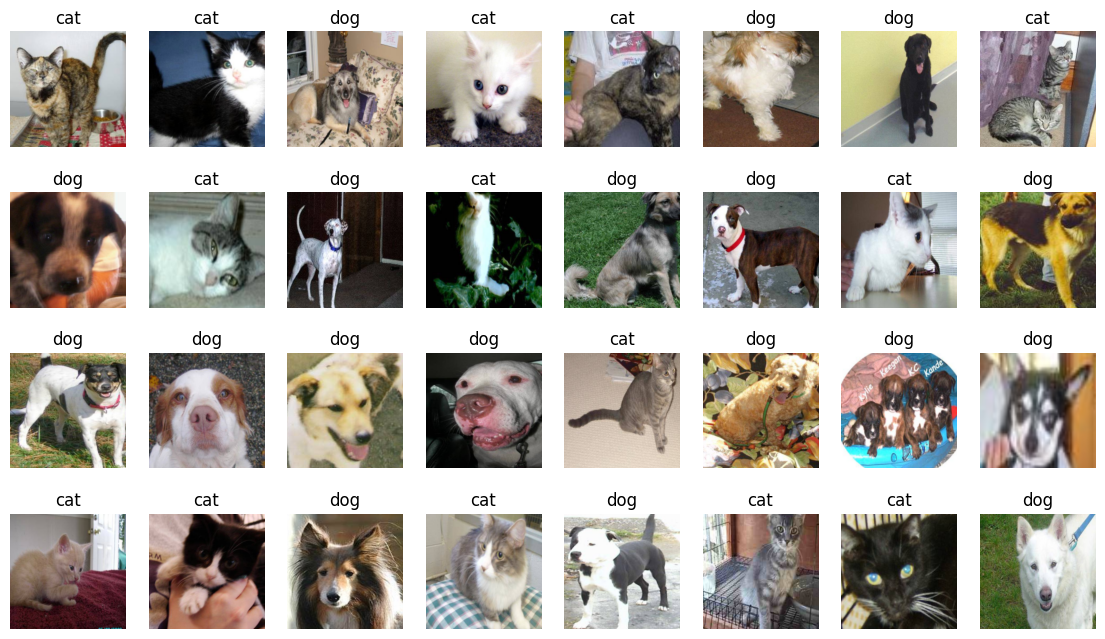

In [34]:
import matplotlib.pyplot as plt

# train데이터가 2000장이 있는데, 32장씩 데이터를 가져온다.
images, labels = next(iter(visual_loader))

classes ={0:'cat',1:'dog'}

fig = plt.figure(figsize=(14, 8))
for i in range(batch_size):
    # 4행 8열
    ax = fig.add_subplot(4, 8, i + 1)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    # 컬러 채널 순서를 재정렬
    ax.imshow(images[i].permute(1, 2, 0))

plt.show()

### resnet50

In [35]:
# 10. 모델 정의 (ResNet50)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

RESNET50 = models.resnet50(pretrained=True).to(device)
num_features = RESNET50.fc.in_features
RESNET50.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


### MOBILENETV3

In [36]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# MobileNetV3 모델 불러오기 (사전 학습된 가중치 사용)
MNV3_large = mobilenet_v3_large(pretrained=True).to(device)

# MobileNetV3의 classifier 레이어 출력 차원 확인
num_features = MNV3_large.classifier[0].in_features

# 2진 분류기로 모델의 마지막 레이어 수정
MNV3_large.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 61.2MB/s]


### MobileNetV3 small

In [37]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# MobileNetV3 모델 불러오기 (사전 학습된 가중치 사용)
MNV3_small = mobilenet_v3_small(pretrained=True).to(device)

# MobileNetV3의 classifier 레이어 출력 차원 확인
num_features = MNV3_small.classifier[0].in_features

# 2진 분류기로 모델의 마지막 레이어 수정
MNV3_small.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 192MB/s]


In [38]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# TorchHub를 통해 MobileNetV3 Small 모델 불러오기
MNV3_small = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_small', pretrained=True)
MNV3_small = MNV3_small.to(device)

# MobileNetV3의 classifier 레이어 출력 차원 확인
num_features = MNV3_small.classifier[0].in_features

# 2진 분류기로 모델의 마지막 레이어 수정
MNV3_small.classifier = torch.nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
).to(device)



Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


In [39]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 사전 학습된 EfficientNet-B2 모델 불러오기
from efficientnet_pytorch import EfficientNet
efficientNetB0 = EfficientNet.from_pretrained('efficientnet-b0')
efficientNetB0 = efficientNetB0.to(device)  # GPU로 모델 이동

# EfficientNet-B2의 마지막 fully connected 레이어 출력 차원 확인
num_features = efficientNetB0._fc.in_features

# 2진 분류기로 모델의 마지막 레이어 수정
efficientNetB0._fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()  # 이진 분류이므로 Sigmoid 활성화 함수 추가
).to(device)

# He 초기화를 적용하는 함수 정의
def initialize_weights_he(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

# 필요한 부분에만 초기화(linear layer, convolutional layer)
# 모델의 마지막 레이어(분류기)에 He 초기화 적용
efficientNetB0._fc.apply(initialize_weights_he)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 130MB/s]


Loaded pretrained weights for efficientnet-b0


Sequential(
  (0): Linear(in_features=1280, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=1, bias=True)
  (4): Sigmoid()
)

In [40]:
# 모델선택
# model = efficientNetB2
model = efficientNetB0
# model = MNV3_large
# model = RESNET50

In [41]:
from torchsummary import summary
summary(model, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [-1, 32, 128, 128]             864
       BatchNorm2d-3         [-1, 32, 128, 128]              64
MemoryEfficientSwish-4         [-1, 32, 128, 128]               0
         ZeroPad2d-5         [-1, 32, 130, 130]               0
Conv2dStaticSamePadding-6         [-1, 32, 128, 128]             288
       BatchNorm2d-7         [-1, 32, 128, 128]              64
MemoryEfficientSwish-8         [-1, 32, 128, 128]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [42]:
# 7. 손실함수 및 옵티마이저 정의
lr = 0.00001
epochs = 15
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.0005)

In [43]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def imshow(img):
    # 이미지 정규화를 해제하기 위해 역변환
    img = img / 2 + 0.5  # (0.5, 0.5, 0.5)로 정규화된 이미지일 경우
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    # 그래프를 출력하기 위해 리스트에 누적
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    # 잘못 예측된 이미지를 저장할 리스트
    wrong_images = []
    wrong_labels = []
    wrong_preds = []

    for epoch in range(epochs):
        start = time.time()

        # tqdm을 사용하여 각 에포크의 진행률 표시
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        # 1 epoch 중에 train에 해당하는 for 문
        for train_x, train_y in train_loader_tqdm:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            # 기울기 초기화
            optimizer.zero_grad()
            # 예측
            pred = model(train_x)
            # 손실계산
            loss = criterion(pred, train_y)
            # 오차역전파
            loss.backward()
            # 진행
            optimizer.step()
            train_loss += loss.item()

            # sigmoid
            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            # y_pred와 train_y값이 같으면 train_correct 추가
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        # tqdm을 사용하여 각 에포크의 validation 진행률 표시
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        # 1 epoch 중에 validation에 해당하는 for 문
        for valid_x, valid_y in valid_loader_tqdm:
            with torch.no_grad():
                model.eval()
                # print(f'valid_x : {valid_x}')
                # print(f'type(valid_x) : {type(valid_x)}')
                # print(f'valid_y : {valid_y}')
                # print(f'type(valid_y) : {type(valid_y)}')
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

            # 잘못 예측한 이미지와 레이블 저장
            wrong_idx = (y_pred != valid_y.cpu()).nonzero(as_tuple=True)[0]
            for idx in wrong_idx:
                wrong_images.append(valid_x.cpu()[idx])  # 잘못 예측된 이미지
                wrong_labels.append(valid_y.cpu()[idx])  # 실제 라벨
                wrong_preds.append(y_pred[idx])          # 예측된 값

        train_acc = train_correct / len(train_loader.dataset)
        valid_acc = valid_correct / len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    # 잘못 예측한 이미지를 시각화
    print(f"잘못 예측한 이미지 수: {len(wrong_images)}")

    # 최대 5개의 잘못 예측된 이미지를 시각화
    for i in range(min(5, len(wrong_images))):
        print(f"실제 라벨: {wrong_labels[i].item()}, 예측값: {wrong_preds[i].item()}")
        imshow(wrong_images[i])

    # 학습 및 검증 손실/정확도 시각화
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()


아래의 코드는 테스트 데이터를 평가하고 시각화하는 함수인데    
레이블이 잇는 테스트 데이터에 한해서 정확도 측정이 가능하다(EX - 레이블이 존재하는 트레인데이터셋에서 테스트 데이터를 분할한 경우)

현재 레이블이 없는 실제 테스트 데이터를 활용할 예정이므로    
시각화를 통해 테스트 데이터를 어떤 레이블로 예측했는지 확인하는 코드를 사용할 예정

In [44]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os
from tqdm import tqdm

# 테스트 데이터에서 성능을 평가하고, 예측이 잘못된 이미지를 시각화하는 함수
def evaluate_and_visualize(model, test_loader, criterion):
    test_loss = 0
    test_correct = 0
    test_total = 0
    incorrect_labels = []
    incorrect_preds = []
    incorrect_filenames = []

    model.eval()
    with torch.no_grad():
        for test_x, test_y, filenames in tqdm(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            test_loss += loss.item()

            # 예측 결과 처리
            y_pred = pred.cpu()
            y_pred = (y_pred >= 0.5).float()

            # 정확도 계산
            test_correct += y_pred.eq(test_y.cpu()).int().sum()
            test_total += test_y.size(0)

            # 잘못된 예측 저장 (각 요소별로 비교)
            for i in range(len(y_pred)):
                if y_pred[i] != test_y.cpu()[i]:  # 예측과 실제가 다른 경우에만 저장
                    incorrect_labels.append(test_y.cpu()[i].numpy())
                    incorrect_preds.append(y_pred[i].numpy())
                    incorrect_filenames.append(filenames[i])

    test_accuracy = test_correct / test_total
    print(f"test_correct:{test_correct}, test_total:{test_total}")
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

    # 예측이 잘못된 이미지 시각화
    fig = plt.figure(figsize=(12, 12))
    for i in range(min(16, len(incorrect_filenames))):
        ax = fig.add_subplot(4, 4, i + 1)
        image = Image.open(os.path.join('sdata/test', incorrect_filenames[i]))
        ax.imshow(image)
        true_label = 'dog' if incorrect_labels[i] == 1 else 'cat'
        pred_label = 'dog' if incorrect_preds[i] == 1 else 'cat'
        ax.set_title(f'Pred: {pred_label}, Label: {true_label}, {incorrect_filenames[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [45]:
#테스트 데이터를 어떻게 예측했는지 샘플 뽑아보기(일단 10개)
def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()  # 평가 모드로 전환
    count = 0  # 시각화한 이미지 개수를 세기 위한 변수
    with torch.no_grad():
        for test_x, filenames in test_loader:
            test_x = test_x.to(device)
            outputs = model(test_x)
            predictions = (outputs > 0.5).float()  # 시그모이드 출력으로 예측
            for i in range(test_x.size(0)):  # 배치 내 각 이미지에 대해
                if count >= num_images:  # 원하는 이미지 개수만 시각화
                    return
                img = test_x[i].cpu().permute(1, 2, 0).numpy()  # 이미지 형태 변환
                predicted_label = "Dog" if predictions[i].item() == 1 else "Cat"
                filename = filenames[i]

                # 이미지와 파일 이름, 예측 결과 시각화
                plt.imshow(img)
                plt.title(f"File: {filename}, Predicted: {predicted_label}")
                plt.axis('off')  # 축 제거
                plt.show()

                count += 1  # 시각화한 이미지 개수 증가


In [46]:
import torch
print(torch.__version__)

print(torch.version.cuda)

2.4.1+cu121
12.1


In [ ]:
# 9. 모델 학습
fit(model, criterion, optimizer, epochs, train_loader, valid_loader)


193.625sec : [Epoch 1/15] -> train loss: 0.3800, train acc: 84.575% / valid loss: 0.1324, valid acc: 97.500%


194.314sec : [Epoch 2/15] -> train loss: 0.1344, train acc: 95.800% / valid loss: 0.0618, valid acc: 98.325%


194.692sec : [Epoch 3/15] -> train loss: 0.0797, train acc: 97.200% / valid loss: 0.0407, valid acc: 98.750%


193.263sec : [Epoch 4/15] -> train loss: 0.0610, train acc: 97.956% / valid loss: 0.0332, valid acc: 98.900%


193.242sec : [Epoch 5/15] -> train loss: 0.0484, train acc: 98.431% / valid loss: 0.0280, valid acc: 98.875%


Epoch 6/15 [Train]:  39%|███▉      | 195/500 [01:05<01:38,  3.09it/s]

In [ ]:
# 테스트 데이터를 통해 성능 평가 및 잘못된 예측 시각화
# 테스트 데이터에 레이블이 있는 경우
evaluate_and_visualize(model, test_loader, criterion)

In [ ]:
# 레이블 없는 테스트 데이터에 대한 시각화 실행
# visualize_predictions(model, test_loader, device)